In [2]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from libs.XY_model import XYSystem
from tqdm import tqdm
import numba as nb
import gudhi as gd

In [57]:
@nb.njit
def get_curl(x):    
    N = x.shape[0]
    curl = []
    ux = cos(x)
    uy = sin(x)
    for i in range(N):
        cu = []
        for j in range(N):
            c = (ux[i, j] - ux[(i+1)%N, (j+1)%N]) + (uy[(i+1)%N, j] - uy[i, (j+1)%N]) 
            c += np.sum(ux[(i-1)%N, (j-1)%N : (j+3)%N]) - \
                    np.sum(ux[(i+2)%N, (j-1)%N : (j+3)%N]) + \
                    \
                    np.sum(uy[(i-1)%N : (i+3)%N, (j-1)%N]) - \
                    np.sum(uy[(i-1)%N : (i+3)%N, (j+2)%N])
            
            c += np.sum(ux[(i-2)%N, (j-2)%N : (j+4)%N]) - \
                    np.sum(ux[(i+3)%N, (j-2)%N : (j+4)%N]) + \
                    \
                    np.sum(uy[(i-2)%N : (i+4)%N, (j-2)%N]) - \
                    np.sum(uy[(i-2)%N : (i+4)%N, (j+3)%N])
                    
            #   c += np.sum(ux[(i-3)%N, (j-3)%N : (j+5)%N]) - \
            #        np.sum(ux[(i+4)%N, (j-3)%N : (j+5)%N]) + \
            #        \
            #        np.sum(uy[(i-3)%N : (i+5)%N, (j-3)%N]) - \
            #        np.sum(uy[(i-3)%N : (i+5)%N, (j+4)%N]) / 49
            cu.append(c)
        curl.append(cu)
             
    curl = np.array(curl)
    return curl

In [58]:
def list2matrix(S):
        N=int(np.size(S))
        L = int(np.sqrt(N))
        S=np.reshape(S,(L,L))
        return S

In [59]:
def plot_heatmap(spin_config, curl, temp, name = 'result', heat = True, just_heat = False):
    N = spin_config.shape[0]
    plt.figure(figsize=(4,4),dpi=800, facecolor='white')
    if(heat):
        plt.imshow(curl)
        plt.colorbar()
    if(just_heat):
        plt.imshow(curl)
        plt.colorbar()
        plt.savefig(f'./images/{name}.png', dpi = 800)
        plt.close()
        return
    X, Y = np.meshgrid(np.arange(0,N),np.arange(0, N))
    U = np.cos(spin_config)
    V = np.sin(spin_config)
    Q = plt.quiver(X, Y, U, V, units='width')
    qk = plt.quiverkey(Q, 0.1, 0.1, 1, r'$spin$', labelpos='E',
                coordinates='figure')
    plt.title('T=%.2f'%temp+', #spins='+str(N)+'x'+str(N))
    plt.savefig(f'./images/{name}.png', dpi = 800)
    plt.close()

In [60]:
def do_monte_carlo(temp, N):
    xy = XYSystem(temperature = temp, width = N)
    xy.equilibrate(show=False)
    return list2matrix(xy.spin_config)

In [61]:
temp = [0.05, 0.6, 0.9, 1.5]
N = 128  

100%|██████████| 4/4 [17:41<00:00, 265.27s/it]


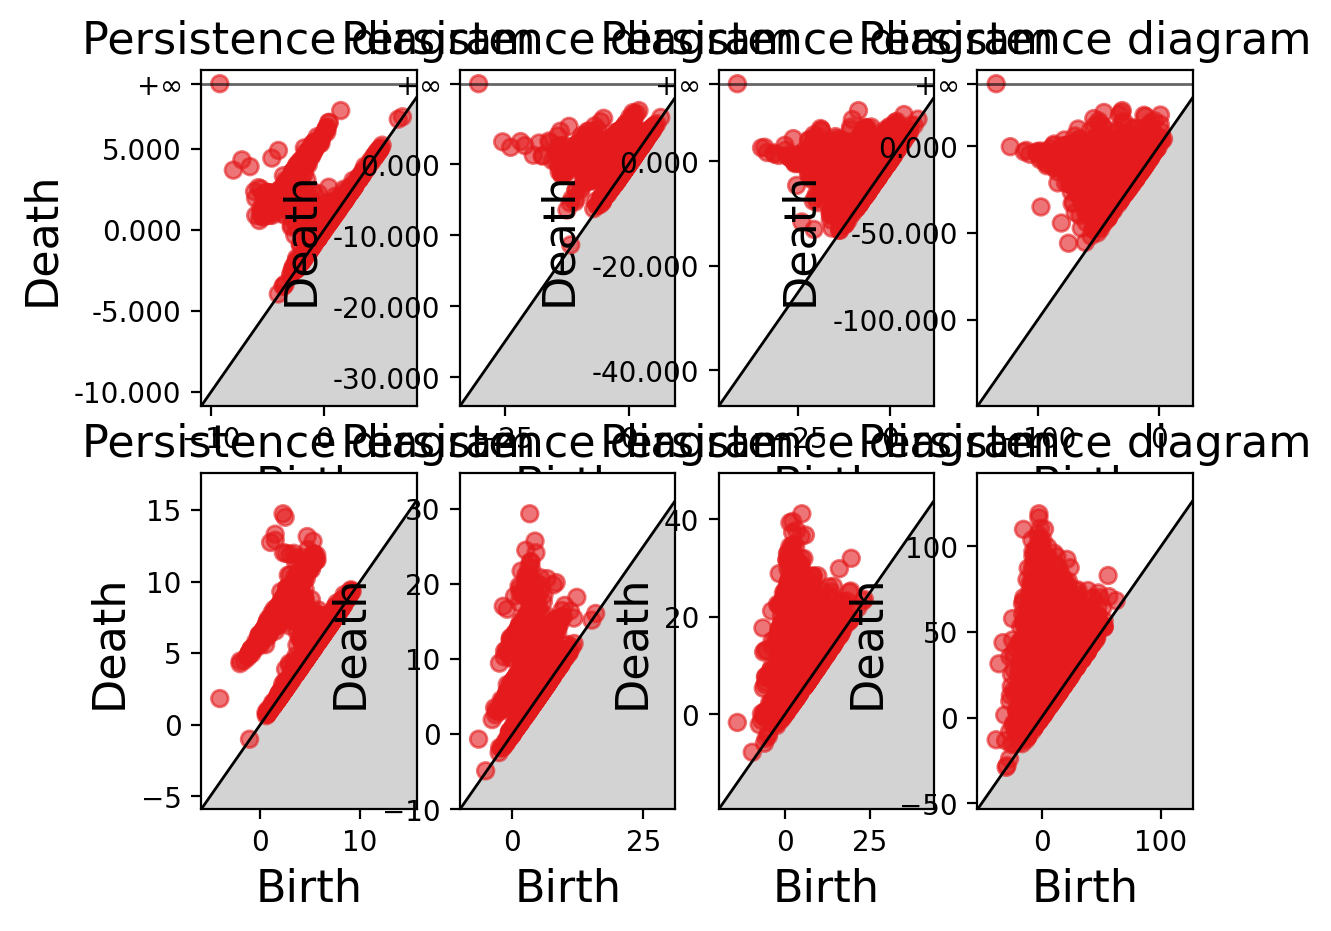

In [62]:
fig, ax = plt.subplots(2, 4 , dpi = 200)
for i in tqdm(range(len(temp))):
    x = do_monte_carlo(temp[i], N)
    cu = get_curl(x)
    cc = gd.CubicalComplex(top_dimensional_cells = x)
    cc.compute_persistence()
    H0 = cc.persistence_intervals_in_dimension(0)
    gd.plot_persistence_diagram(H0, axes=ax[0][i])
    H1 = cc.persistence_intervals_in_dimension(1)
    gd.plot_persistence_diagram(H1, axes=ax[1][i])
        